## Velocity structure

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as scipy
import cmocean
import math
import gsw
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

plt.rcParams['font.size'] = '14'

In [2]:
workingdir = r'C:\Users\mijakes\checkouts\phd-public'
os.chdir(workingdir) 

import imp
import src.importData as imports
import src.calc as calc
import src.interpolation as interp
import src.plots as plots
import src.stats as stats
import src.concat as ct
import src.velocities as vel
import src.settings as settings

In [3]:
# Import satellite altimetry data 
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')
alt_cmems = imports.importNetCDF(datadir, 'CMEMS.nc', datatype ='altimetry')

In [4]:
# Path to save figures
my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter2_manuscript')

### EM-APEX

In [5]:
fltdir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
floatids = [8489, 8492, 8493]
ema = imports.importFloatData(floatids)

In [6]:
rot_vels = {}
for floatid in floatids:
    #rotated velocities
    file = os.path.join(fltdir, 'rotated_velocity', 'by_profile', 'rot_vel_%s.nc' %floatid)
    rot_vels[floatid] = xr.open_dataset(file)

# half-inertial pair averaged float dataset
imp.reload(imports)
ds = imports.sub_inertial_ds(ema, floatids, fltdir, xdim = 'distance', rot_vels = rot_vels)

In [7]:
# import mixing estimes (diffusivity and dissipation rates) from Ajitha Cyraic et al. (2022)
mixing_ds = imports.importNetCDF(datadir, 'mixing_estimates_ajitha.nc', datatype ='mixing_ajitha')

### Calculate variables

In [8]:
floatids = [8489, 8492, 8493]

d = {}
CT, SA, P = {}, {}, {}
dyn_m = {}
mld_on_d = {}
mld = {}
N2 = {}
dens = {}

for floatid in floatids:
    pressure = np.tile(ds[floatid].pressure, (len(ds[floatid].CT), 1))
    ds[floatid]['P'] = xr.DataArray(pressure, dims = ds[floatid].CT.dims, 
                                  coords = ds[floatid].CT['pressure'].coords)

    CT[floatid], SA[floatid], P[floatid] = ds[floatid].CT, ds[floatid].SA, ds[floatid].P
    
    dens[floatid] = calc.potentialDensity(P[floatid], SA[floatid], CT[floatid])
    
    dyn_m[floatid] = calc.dynamicHeight(SA[floatid], CT[floatid])[1] 
    mld_on_d[floatid] = calc.MLD_on_dens(dens[floatid], criteria = 0.03, pref = 10)
    mld[floatid] = calc.MLD(dens[floatid], criteria = 0.03, pref = 10)
    
    N2[floatid] = calc.N2(CT[floatid], SA[floatid], ds[floatid].latitude, smooth = False)
    

In [9]:
S_concat = ct.joinFloats(SA, 'distance', new_dim = False)
T_concat = ct.joinFloats(CT, 'distance', new_dim = False)
pdens_ct = ct.joinFloats(dens, 'distance', new_dim = False)

Tdens_ds, end_dist, d_rs = ct.concatenated_flts(CT, floatids, interp_to_dens = True, pdens = pdens_ct, new_dim = False, rs = False)
Sdens_ds, end_dist, d_rs = ct.concatenated_flts(SA, floatids, interp_to_dens = True, pdens = pdens_ct, new_dim = False, rs = False)

ticks, values, flt_dist_loc = plots.concatTickValues(d_rs)
flt_ind = np.where(Tdens_ds.distance == 0)[0].tolist()
flt_ind.append(len(Tdens_ds))

In [10]:
imp.reload(calc)
DSC = {}
DSC_smooth = {}
S_dens, T_dens = {}, {}
p_on_dens = {}

i = 0 
for floatid in floatids:
    
    S = Sdens_ds[flt_ind[i]:flt_ind[i+1]]
    T = Tdens_ds[flt_ind[i]:flt_ind[i+1]]
    density = pdens_ct[flt_ind[i]:flt_ind[i+1]]
    S_dens[floatid], T_dens[floatid] = S, T

    DSC[floatid], DSC_smooth[floatid] = calc.DSC(T, S, pdens = density, dens_interval = 0.01)
    
    p_on_dens[floatid] = interp.to_pdens_grid(P[floatid], density, zdim = 'pressure', dens_interval = 0.01)
    
    i += 1

In [11]:
DSC_concat = ct.joinFloats(DSC_smooth, 'distance', new_dim = True)
dyn_m_concat = ct.joinFloats(dyn_m, 'distance', new_dim = True)
mld_concat = ct.joinFloats(mld_on_d, 'distance', new_dim = True)

pdens_mid = pdens_ct.interp(pressure = N2[floatid].pressure)
N2_concat, end_dist, N2_rs = ct.concatenated_flts(N2, floatids, interp_to_dens = True, pdens = pdens_mid, new_dim = True)

ticks, values, flt_dist_loc = plots.concatTickValues(N2_rs)

### Mixing rates from Cyriac et al. (2022)

In [12]:
def remove_drift(var):
    # remove drift profiles
    ind = []
    for i in range(0, len(var)):
        nans = np.where(np.isnan(var[i]))[0]
        if len(nans) != len(var[i]):
            ind.append(i)
    return var[ind], ind

In [13]:
kappa = {}
epsilon = {}
kappa_on_d = {}
epsilon_on_d = {}

for floatid in floatids:
    rs = calc.findRSperiod(ema[floatid])

    data_k = mixing_ds[f'diffusivity{str(floatid)[-2:]}'][rs]
    data_e = mixing_ds[f'epsilon{str(floatid)[-2:]}'][rs]

    xdim = f'profile{str(floatid)[-2:]}'
    prof = np.arange(0,len(data_k))
    data_k[xdim] = prof
    data_e[xdim] = prof
    
    ind = slice(0, len(prof))

    k = xr.DataArray(np.log10(data_k)[ind].data, dims = ['distance', 'pressure'], coords = dict(pressure = ('pressure', data_k.pressure.data),
                                                                              distance = ('distance', ds[floatid].distance[ind].data)))
    
    e = xr.DataArray(np.log10(data_e)[ind].data, dims = ['distance', 'pressure'], coords = dict(pressure = ('pressure', data_e.pressure.data),
                                                                          distance = ('distance', ds[floatid].distance[ind].data)))
    
    k = interp.new_pressure_grid(k, ds[floatid].pressure, zdim = 'pressure')
    e = interp.new_pressure_grid(e, ds[floatid].pressure, zdim = 'pressure')
    
    kappa[floatid] = k
    epsilon[floatid] = e
    
    ind = remove_drift(k)[1]
    
    kappa_on_d[floatid] = interp.varToDens(remove_drift(k)[0], pdens = dens[floatid][ind], dens_interval = 0.01, by_dist = True, rs = False)
    epsilon_on_d[floatid] = interp.varToDens(remove_drift(e)[0], pdens = dens[floatid][ind], dens_interval = 0.01, by_dist = True, rs = False)

In [14]:
kappa_ct = ct.joinFloats(kappa, 'distance', new_dim = True)
kappa_ct, ind = remove_drift(kappa_ct)
eps_ct = ct.joinFloats(epsilon, 'distance', new_dim = True)
eps_ct, ind = remove_drift(eps_ct)

In [15]:
kappa_dens = interp.varToDens(kappa_ct, pdens = pdens_ct[ind], dens_interval = 0.01, by_dist = True, rs = False)
eps_dens = interp.varToDens(eps_ct, pdens = pdens_ct[ind], dens_interval = 0.01, by_dist = True, rs = False)

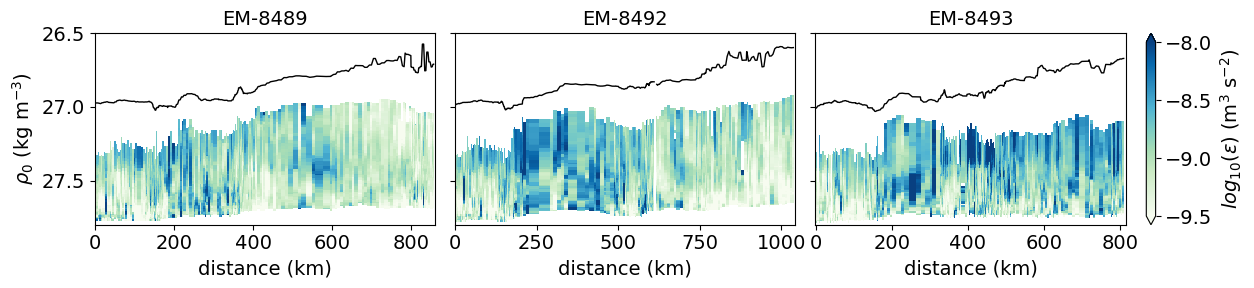

In [44]:
#dissipation rate
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.1))
axs = ax.flatten()

i = 0
for floatid in floatids:
    im = epsilon_on_d[floatid].plot(ax = axs[i], x = 'distance', vmin = -9.5, vmax = -8, cmap = 'GnBu', add_colorbar = False)
    
#     DSC_smooth[floatid].plot.contour(ax = axs[i],x = 'distance', cmap = 'PiYG', levels = [-2, 2], 
#                                      linewidths = 1, alpha = 0.9, linestyles = 'solid', add_colorbar = False)

    mld_on_d[floatid].plot(ax = axs[i], c = 'k', linewidth = 1)
#     CS = p_on_dens[floatid].plot.contour(ax = axs[i],
#                                         x = 'distance', 
#                                         levels = np.arange(0, 1000, 200),
#                                         linewidths = 0.6, 
#                                         colors = 'k', 
#                                         alpha = 0.4)
    
#     axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.0f')
    
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(26.5, 27.8)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\rho_{0}$ (kg m$^{-3}$)')
axs[1].set_xlabel('distance (km)')


plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = '$log_{10}(\epsilon)$ (m$^{3}$ s$^{-2}$)', extend = 'both')

# settings.save_figure(fig, my_path, 'dissipation_rate.png', dpi = 600, pad = 0.2)

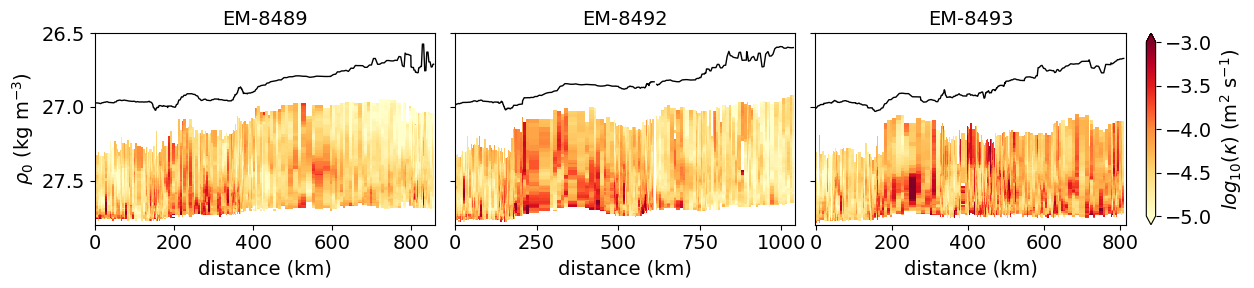

In [45]:
#diffusivity
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.1))
axs = ax.flatten()

i = 0
for floatid in floatids:
    im = kappa_on_d[floatid].plot(ax = axs[i], x = 'distance', vmin = -5, vmax = -3, cmap = 'YlOrRd', add_colorbar = False)
        
#     DSC_smooth[floatid].plot.contour(ax = axs[i],x = 'distance', cmap = 'PiYG', levels = [-2, 2], 
#                                      linewidths = 1, alpha = 0.9, linestyles = 'solid', add_colorbar = False)

    mld_on_d[floatid].plot(ax = axs[i], c = 'k', linewidth = 1)
    
#     CS = p_on_dens[floatid].plot.contour(ax = axs[i],
#                                         x = 'distance', 
#                                         levels = np.arange(0, 1000, 200),
#                                         linewidths = 0.6, 
#                                         colors = 'k', 
#                                         alpha = 0.4)
    
#     axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.0f')
    
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(26.5, 27.8)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\rho_{0}$ (kg m$^{-3}$)')
axs[1].set_xlabel('distance (km)')


plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = '$log_{10}(\kappa)$ (m$^{2}$ s$^{-1}$)', extend = 'both')

# settings.save_figure(fig, my_path, 'diffusivity.png', dpi = 600, pad = 0.2)

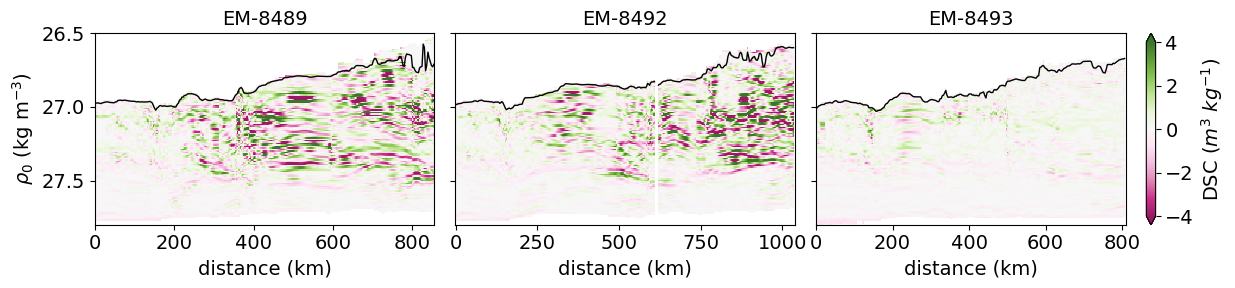

In [46]:
#DSC
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.1))
axs = ax.flatten()

i = 0
for floatid in floatids:
    dsc_even = interp.even_dist_grid(DSC_smooth[floatid], 3)
    p_on_d_even = interp.even_dist_grid(p_on_dens[floatid], 3)
    mld_even = interp.even_dist_grid(mld_on_d[floatid], 3)
    
    im = dsc_even.plot(ax = axs[i],x = 'distance', cmap = 'PiYG', vmin = -4, vmax = 4, alpha = 0.9, add_colorbar = False)
    
    mld_even.plot(ax = axs[i], c = 'k', linewidth = 1)
    
#     CS = p_on_d_even.plot.contour(ax = axs[i],
#                                         x = 'distance', 
#                                         levels = np.arange(0, 1000, 200),
#                                         linewidths = 0.6, 
#                                         colors = 'k', 
#                                         alpha = 0.4)
    
#     axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.0f')
    
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(26.5, 27.8)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\rho_{0}$ (kg m$^{-3}$)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = "DSC ($m^{3}$ $kg^{-1}$)", extend = 'both')

# settings.save_figure(fig, my_path, 'dsc_3_floats.png', dpi = 600, pad = 0.2)

### Vertical shear

In [16]:
DSC_even_grid = {}
Ri_even_d = {}
Ri = {}
shear = {}
speed = {}
dU_dx = {}

imp.reload(calc)

for floatid in floatids:
    Ri[floatid], shear[floatid]  = calc.RiNumber(N2[floatid], lat = ds[floatid].latitude, 
                                                             u = ds[floatid].u_abs, 
                                                             v = ds[floatid].v_abs, 
                                                             smooth_vels = True,
                                                             window = 15)
    
    Ri_even_d[floatid] = interp.even_dist_grid(Ri[floatid], 3).rolling(distance = 3, center = True, min_periods = 1).mean()
    
    DSC_even_grid[floatid] = interp.even_dist_grid(DSC_smooth[floatid], 3)
    speed[floatid] = calc.speed(ds[floatid].u_abs, ds[floatid].v_abs)
    dU_dx[floatid] = speed[floatid].differentiate('distance')/1000

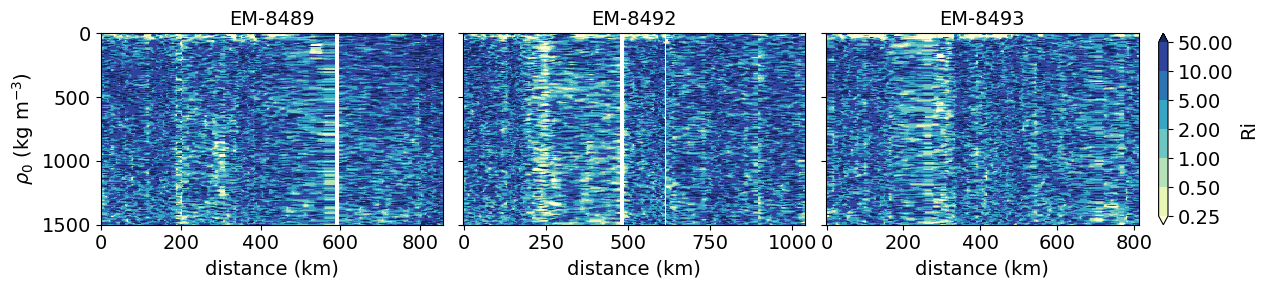

In [17]:
# Richardson number
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.1))
axs = ax.flatten()

i = 0
for floatid in floatids:
    im = Ri_even_d[floatid].plot(ax = axs[i], x = 'distance', levels = [0.25, 0.5, 1, 2, 5, 10, 50], cmap = 'YlGnBu', 
                          alpha = 0.95, add_colorbar = False)
    
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(0, 1500)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\rho_{0}$ (kg m$^{-3}$)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = "Ri", extend = 'both')

# settings.save_figure(fig, my_path, 'Float_Ri.png', dpi = 600, pad = 0.2)

In [302]:
# # on density
# Ri_ct_dens, end_dist, Ri_dict_dens = ct.concatenated_flts(Ri, floatids, interp_to_dens = True, pdens = pd_even_concat, new_dim = True, rs = False)
# low_Ri = calc.percent_below_mL(Ri_ct_dens, mld_ct_even, condition = '<= 1', dim = 'potential_density')

In [303]:
# N2_ct_even, end_dist, N2_even_dict = ct.concatenated_flts(N2_gridded, floatids, interp_to_dens = True, pdens = pd_even_concat, new_dim = True, rs = False)
# dsc_ct_even = ct.joinFloats(DSC_even_grid, 'distance', new_dim = True).interp(potential_density = N2_ct_even.potential_density)

### Buoyancy reynolds number 


$Re_{b} = ɛ / (νN^{2})$

In [18]:
# kinematic viscosity
nu = 1.5e-6 # (Talley et al. 2011, Chapter 7: Dynamical Processes for Descriptive Ocean Circulation).

In [19]:
10**-9.5 / (nu*1.8e-5)

11.712139482105108

In [20]:
10**-9.5 / (nu*0.8e-5)

26.352313834736496

[Text(1, 0.0, '1'),
 Text(1, 1.0, '10'),
 Text(1, 2.0, '100'),
 Text(1, 3.0, '1000')]

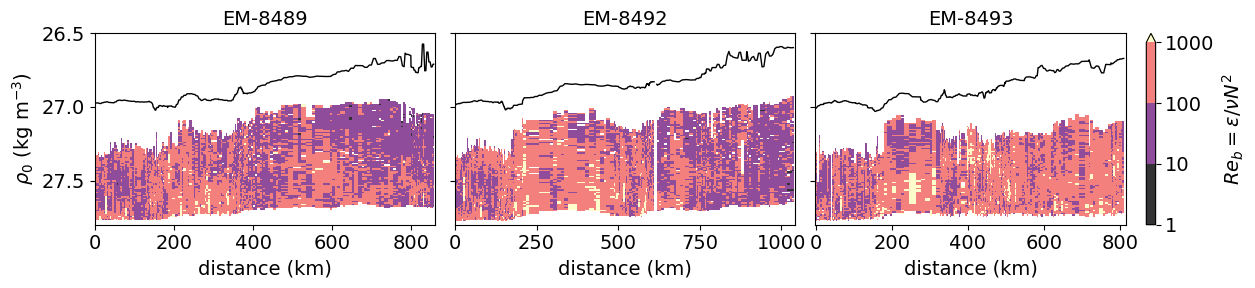

In [21]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.1))
axs = ax.flatten()

Re_b = {}
i = 0
for floatid in floatids:
    e = (10**epsilon_on_d[floatid]).interp(potential_density = N2_rs[floatid].potential_density)
    n2 = N2_rs[floatid].interp(distance = epsilon_on_d[floatid].distance)
    Re_b[floatid] = e/(nu*n2)
    
    im = np.log10(Re_b[floatid]).plot(ax = axs[i], x = 'distance', cmap = 'magma', alpha = 0.8,
                             add_colorbar = False, levels = [0, 1, 2, 3])
           
#     DSC_smooth[floatid].plot.contour(ax = axs[i],x = 'distance', cmap = 'PiYG', levels = [-2, 2], 
#                                      linewidths = 1, alpha = 0.9, linestyles = 'solid', add_colorbar = False)

    mld_on_d[floatid].plot(ax = axs[i], c = 'k', linewidth = 1)
    
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(26.5, 27.8)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\rho_{0}$ (kg m$^{-3}$)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
cb = plt.colorbar(im, cax, label = r'$Re_{b} = \epsilon / \nu N^{2}$')
cb.ax.set_yticklabels(['1', '10', '100', '1000']) 

In [163]:
# settings.save_figure(fig, my_path, 'EM_buoyancy_reynolds_number.png', dpi = 600, pad = 0.2)

### Scatter plots

In [22]:
mld_on_d = {}
for floatid in floatids:
    mld_on_d[floatid] = calc.MLD_on_dens(dens[floatid], criteria = 0.03, pref = 10, dz = 10) #10 dbar below ML  
    
mld_concat = ct.joinFloats(mld_on_d, 'distance', new_dim = True)

In [23]:
N2_ct = ct.joinFloats(N2, 'distance', new_dim = True)
Re_ct = ct.joinFloats(Re_b, 'distance', new_dim = True)

In [24]:
# mean below the mixed layer to 27.5 kg/m3
dens_min = mld_concat
dens_max = np.tile(27.5, len(dens_min))

avg_kappa = calc.average_in_density_on_pgrid(kappa_ct, pdens_ct[ind].data, dens_min.data, dens_max)
avg_eps= calc.average_in_density_on_pgrid(eps_ct, pdens_ct[ind].data, dens_min.data, dens_max)
avg_N2 = calc.average_in_density_on_pgrid(N2_ct, pdens_ct.data, dens_min.data, dens_max)
avg_Re = calc.average_in_density_on_pgrid(np.log10(Re_ct), pdens_ct[ind].data, dens_min.data, dens_max)

In [25]:
# mean below the mixed layer
avg_dsc = calc.mean_below_ml(abs(DSC_concat), mld_concat, zmax = 27.5)
# avg_N2 = calc.mean_below_ml(N2_concat, mld_concat, zmax = 27.5)
# avg_kappa = calc.mean_below_ml(kappa_dens, mld_concat[ind], zmax = 27.5)

In [26]:
np.nanmean(avg_N2)

1.0020995451510934e-05

In [27]:
N2_cutoff = np.nanmedian(avg_N2)
low_N2 = np.where(avg_N2[ind] < N2_cutoff)[0]

Pearsons corr: -0.391, p-value: 1.22e-22
Pearsons corr: -0.544, p-value: 4.39e-23


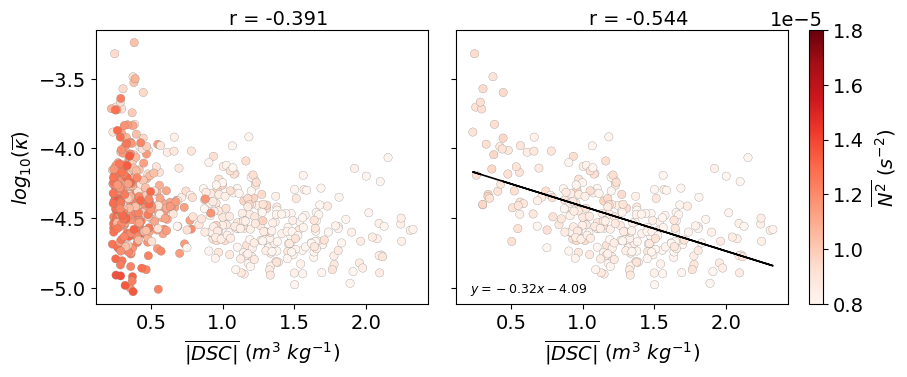

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, figsize = (8.2,4))

x = avg_dsc[ind]
y = avg_kappa 
c = avg_N2[ind]

im1 = ax1.scatter(x, y, c = c, cmap = 'Reds', vmin = 0.8e-5, vmax = 1.8e-5, edgecolors = 'grey', linewidth = 0.2)

# plt.colorbar(im, ax = ax1, label = '$\overline{N^{2}}$ $(s^{-2})$')
ax1.set_ylabel('$log_{10}(\overline{\kappa})$')
ax1.set_xlabel('$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')

r, p = stats.pearsons(x, y, print_info = True)
ax1.text(0.4, 1.02, f'r = {r:.3f}', transform = ax1.transAxes)


#LOW N2 
x = x[low_N2]
y = y[low_N2]
c = c[low_N2]

im2 = ax2.scatter(x, y, c = c, cmap = 'Reds', vmin = 0.8e-5, vmax = 1.8e-5, edgecolors = 'grey', linewidth = 0.2)

#linear fit
nonans = np.where(~np.isnan(x*y))[0]
m, b = np.polyfit(x[nonans], y[nonans], 1)
yfit = [(m * xi) + b for xi in x[nonans]]
ax2.plot(x[nonans], yfit, c = 'k', linewidth = 1.2)
line = f'$y = {m:.2f}x {b:.2f}$'
ax2.text(0.04, 0.04, line, transform = ax2.transAxes, fontsize = 9)

ax2.set_xlabel('$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')

r, p = stats.pearsons(x, y, print_info = True)
ax2.text(0.4, 1.02, f'r = {r:.3f}', transform = ax2.transAxes)

# plt.tight_layout()
plt.tight_layout(w_pad = 1.2)

cax = plt.axes([1, 0.21, 0.017, 0.685])
plt.colorbar(im1, cax = cax, label =('$\overline{N^{2}}$ $(s^{-2})$'))

# settings.save_figure(fig, my_path, 'flt_DSC_K_scatter_fit.png', dpi = 600, pad = 0.2)

In [42]:
print("gradient: ", m)
print("intercept:", b)

gradient:  -0.32126026113177536
intercept: -4.09378633950551


Pearsons corr: -0.534, p-value: 3.77e-44
Pearsons corr: -0.576, p-value: 2.38e-26


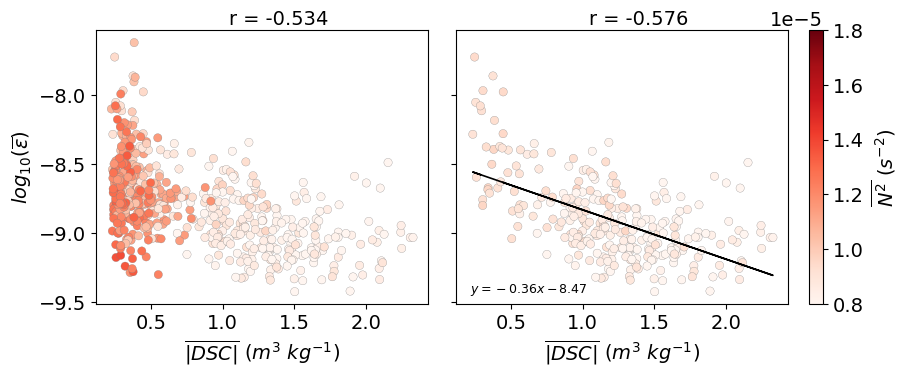

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, figsize = (8.2,4))

x = avg_dsc[ind]
y = avg_eps
c = avg_N2[ind]

im1 = ax1.scatter(x, y, c = c, cmap = 'Reds', vmin = 0.8e-5, vmax = 1.8e-5, edgecolors = 'grey', linewidth = 0.2)

ax1.set_ylabel('$log_{10}(\overline{\epsilon})$')
ax1.set_xlabel('$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')

r, p = stats.pearsons(x, y, print_info = True)
ax1.text(0.4, 1.02, f'r = {r:.3f}', transform = ax1.transAxes)


#LOW N2 
x = x[low_N2]
y = y[low_N2]
c = c[low_N2]

im2 = ax2.scatter(x, y, c = c, cmap = 'Reds', vmin = 0.8e-5, vmax = 1.8e-5, edgecolors = 'grey', linewidth = 0.2)

#linear fit
nonans = np.where(~np.isnan(x*y))[0]
m, b = np.polyfit(x[nonans], y[nonans], 1)
yfit = [(m * xi) + b for xi in x[nonans]]
ax2.plot(x[nonans], yfit, c = 'k', linewidth = 1.2)
line = f'$y = {m:.2f}x {b:.2f}$'
ax2.text(0.04, 0.04, line, transform = ax2.transAxes, fontsize = 9)

ax2.set_xlabel('$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')

r, p = stats.pearsons(x, y, print_info = True)
ax2.text(0.4, 1.02, f'r = {r:.3f}', transform = ax2.transAxes)

# plt.tight_layout()
plt.tight_layout(w_pad = 1.2)

cax = plt.axes([1, 0.21, 0.017, 0.685])
plt.colorbar(im1, cax = cax, label =('$\overline{N^{2}}$ $(s^{-2})$'))

# settings.save_figure(fig, my_path, 'flt_DSC_eps_scatter_fit.png', dpi = 600, pad = 0.2)

In [45]:
print("gradient: ", m)
print("intercept:", b)

gradient:  -0.3579834115482593
intercept: -8.47302359274432


In [612]:
## density coordinates
# shear_ct, end_dist, shear_dict = ct.concatenated_flts(shear, floatids, interp_to_dens = True, pdens = pdens_ct, new_dim = True, rs = False)
# speed_ct, end_dist, speed_dict = ct.concatenated_flts(speed, floatids, interp_to_dens = True, pdens = pdens_ct, new_dim = True, rs = False)
# dUdx_ct, end_dist, dUdx_dict = ct.concatenated_flts(dU_dx, floatids, interp_to_dens = True, pdens = pdens_ct, new_dim = True, rs = False)

In [21]:
# pressure coordinates
shear_ct = ct.joinFloats(shear, 'distance', new_dim = True)
speed_ct = ct.joinFloats(speed, 'distance', new_dim = True)

In [22]:
# mean below the mixed layer to 27.5 kg/m3
dens_min = mld_concat
dens_max = np.tile(27.5, len(dens_min))

avg_shear = calc.average_in_density_on_pgrid(shear_ct, pdens_ct.data, dens_min.data, dens_max)
avg_speed= calc.average_in_density_on_pgrid(speed_ct, pdens_ct.data, dens_min.data, dens_max)

Pearsons corr: -0.437, p-value: 6.27e-38


Text(0.4, 1.02, 'r = -0.437')

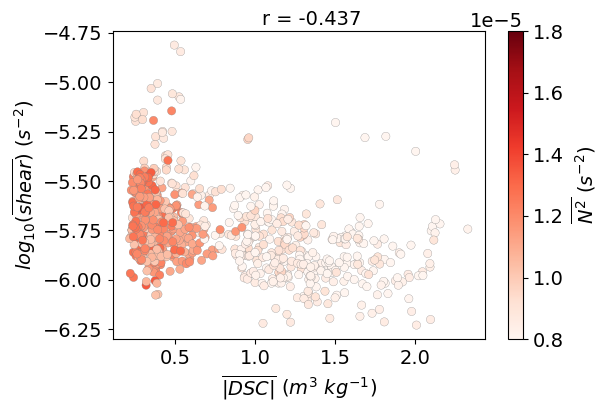

In [23]:
x = avg_dsc
y = np.log10(avg_shear)
c = avg_N2

fig, ax = plt.subplots(figsize = (6,4))
im = plt.scatter(x, y, c = c, cmap = 'Reds', vmin = 0.8e-5, vmax = 1.8e-5, edgecolors = 'grey', linewidth = 0.2)
plt.colorbar(im, label = '$\overline{N^{2}}$ $(s^{-2})$')
# plt.ylabel('shear ($s^{-2}$)')
plt.ylabel('$log_{10}(\overline{shear})$ ($s^{-2}$)')
plt.xlabel('$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')

r, p = stats.pearsons(x, y, print_info = True)

ax.text(0.4, 1.02, f'r = {r:.3}', transform = ax.transAxes)

# settings.save_figure(fig, my_path, 'Float_scatter_DSC_shear.png', dpi = 600, pad = 0.2)

Pearsons corr: 0.241, p-value: 7.63e-12


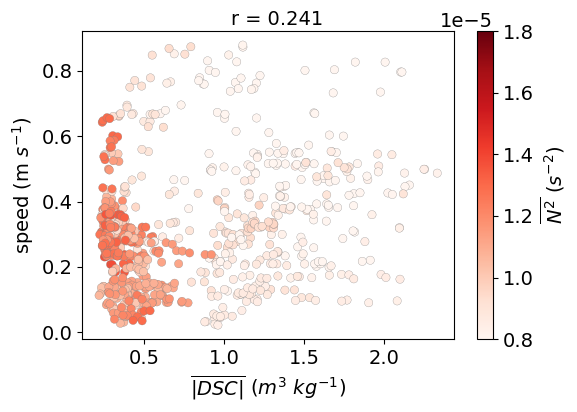

In [674]:
x = avg_dsc
y = avg_speed
c = avg_N2

fig, ax = plt.subplots(figsize = (6,4))
im = plt.scatter(x, y, c = c, cmap = 'Reds', vmin = 0.8e-5, vmax = 1.8e-5, edgecolors = 'grey', linewidth = 0.2)
plt.colorbar(im, label = '$\overline{N^{2}}$ $(s^{-2})$')
plt.ylabel('speed (m $s^{-1}$)')
plt.xlabel('$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')

r, p = stats.pearsons(x, y, print_info = True)

ax.text(0.4, 1.02, f'r = {r:.3}', transform = ax.transAxes)

# settings.save_figure(fig, my_path, 'Float_scatter_DSC_speed.png', dpi = 600, pad = 0.2)

Pearsons corr: -0.439, p-value: 5.71e-28
Pearsons corr: -0.614, p-value: 3.93e-29


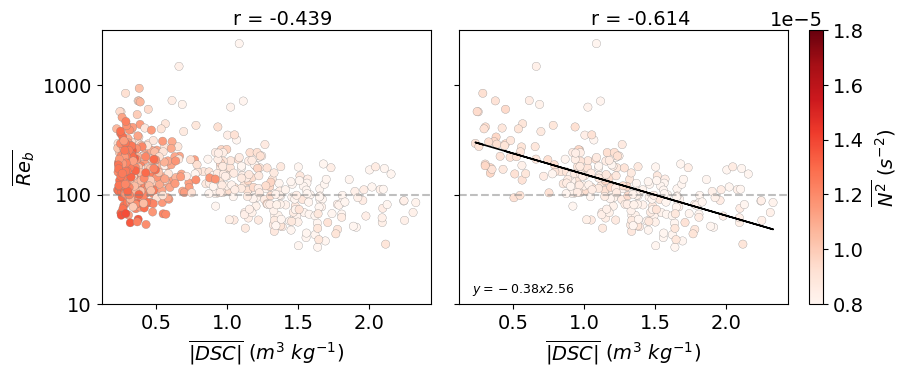

In [222]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, figsize = (8.2,4))

x = avg_dsc[ind]
y = avg_Re
c = avg_N2[ind]

im1 = ax1.scatter(x, y, c = c, cmap = 'Reds', vmin = 0.8e-5, vmax = 1.8e-5, edgecolors = 'grey', linewidth = 0.2)
ax1.axhline(y = 2, linestyle = '--', c = 'grey', alpha = 0.5)

ax1.set_ylabel('$\overline{Re_{b}}$')
ax1.set_xlabel('$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')

r, p = stats.pearsons(x, y, print_info = True)
ax1.text(0.4, 1.02, f'r = {r:.3f}', transform = ax1.transAxes)

ax1.set_ylim(1, 3.5)
ax1.set_yticks([1, 2, 3])
ax1.set_yticklabels([10, 100, 1000])

#LOW N2 
x = x[low_N2]
y = y[low_N2]
c = c[low_N2]

im2 = ax2.scatter(x, y, c = c, cmap = 'Reds', vmin = 0.8e-5, vmax = 1.8e-5, edgecolors = 'grey', linewidth = 0.2)
ax2.axhline(y = 2, linestyle = '--', c = 'grey', alpha = 0.5)

#linear fit
nonans = np.where(~np.isnan(x*y))[0]
m, b = np.polyfit(x[nonans], y[nonans], 1)
yfit = [(m * xi) + b for xi in x[nonans]]
ax2.plot(x[nonans], yfit, c = 'k', linewidth = 1.2)
line = f'$y = {m:.2f}x {b:.2f}$'
ax2.text(0.04, 0.04, line, transform = ax2.transAxes, fontsize = 9)

ax2.set_xlabel('$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')

r, p = stats.pearsons(x, y, print_info = True)
ax2.text(0.4, 1.02, f'r = {r:.3f}', transform = ax2.transAxes)

# plt.tight_layout()
plt.tight_layout(w_pad = 1.2)

cax = plt.axes([1, 0.21, 0.017, 0.685])
plt.colorbar(im1, cax = cax, label =('$\overline{N^{2}}$ $(s^{-2})$'))

# settings.save_figure(fig, my_path, 'flt_DSC_Re.png', dpi = 600, pad = 0.2)

Pearsons corr: 0.793, p-value: 3.04e-123


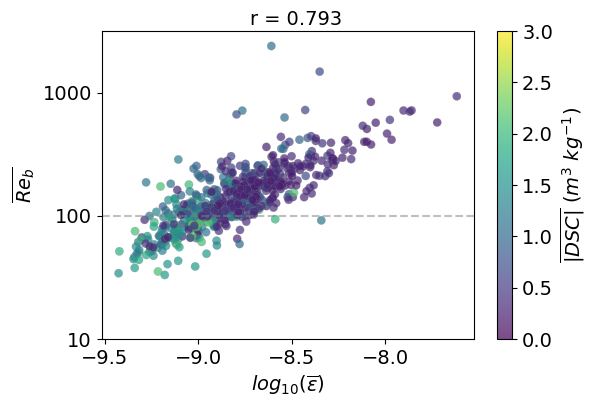

In [223]:
x = avg_eps
y = avg_Re
c = avg_dsc[ind]

fig, ax = plt.subplots(figsize = (6,4))
im = ax.scatter(x, y, c = c, cmap = 'viridis', vmin = 0, vmax = 3, alpha = 0.7, edgecolors = 'grey', linewidth = 0.2)
ax.axhline(y = 2, linestyle = '--', c = 'grey', alpha = 0.5)

plt.colorbar(im, label = '$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')

ax.set_ylabel('$\overline{Re_{b}}$')
ax.set_xlabel('$log_{10}(\overline{\epsilon})$')

r, p = stats.pearsons(x, y, print_info = True)
ax.text(0.4, 1.02, f'r = {r:.3}', transform = ax.transAxes)

ax.set_ylim(1, 3.5)
ax.set_yticks([1, 2, 3])
ax.set_yticklabels([10, 100, 1000])

# settings.save_figure(fig, my_path, 'flt_Re_eps.png', dpi = 600, pad = 0.2)

### Diffusive timescale $t_{K} = H^{2}/K$ (Shcherbina et al., 2009) 


In [28]:
def diffusive_timescale(H, K):
    t_k = H**2/K #seconds
    t_k = t_k/86400 #convert to days
    return t_k

In [29]:
diffusive_timescale(10, 1e-5)

115.74074074074075

In [30]:
H = np.arange(10,60,10)

In [31]:
K_log = np.arange(-3, -6, -1)
K_log = [-3]

[ 1.15740741  4.62962963 10.41666667 18.51851852 28.93518519]


Text(0, 0.5, '$t_{K}$ (days)')

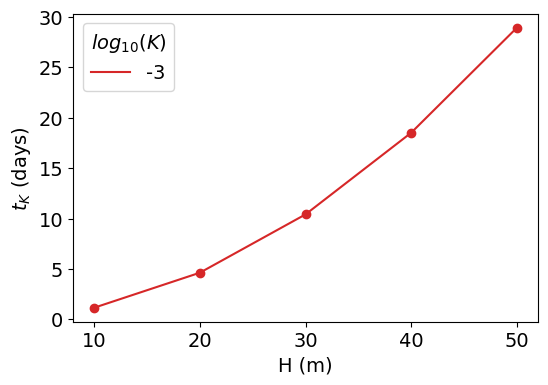

In [32]:
fig, ax = plt.subplots(figsize = (6,4))

for kappa in K_log:
    K = 10**float(kappa)
    t_k = diffusive_timescale(H, K)
    print(t_k)
    plt.plot(H, t_k, c = 'tab:red')
    plt.scatter(H, t_k,  c = 'tab:red')
    
plt.legend(K_log, title = '$log_{10}(K)$')
# plt.yscale('log')
plt.xlabel('H (m)')
plt.ylabel('$t_{K}$ (days)')

In [33]:
t_k

array([ 1.15740741,  4.62962963, 10.41666667, 18.51851852, 28.93518519])

In [34]:
K = 1e-3
f = 0.0001

In [35]:
(1/f)/8600

1.1627906976744187

In [36]:
np.sqrt(2*np.pi*(K/f))

7.926654595212022

## Relationship between dissipation rate and stratification

In [37]:
def dissipation_rate(kappa, N2, mixing_efficiency = 0.2):
    eps = (kappa*N2)/mixing_efficiency
    return eps

def diffusivity(eps, N2, mixing_efficiency = 0.2):
    kappa = (eps*mixing_efficiency)/N2
    return kappa

In [38]:
N2_range = np.arange(0.8e-5, 2e-5, 0.2e-5)

In [39]:
K_log = np.arange(-3.5, -5.5, -0.5)

Text(0, 0.5, '$\\epsilon$ (m$^{3}$ s$^{-2}$)')

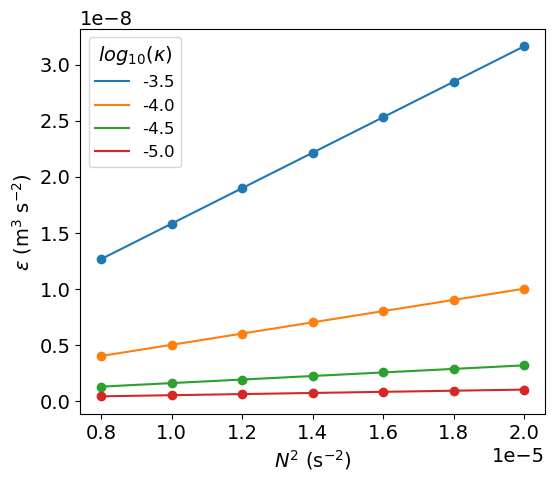

In [40]:
fig, ax = plt.subplots(figsize = (6,5))

for kappa in K_log:
    K = 10**float(kappa)
    
    eps = dissipation_rate(K, N2_range)
    
    plt.plot(N2_range, eps)
    plt.scatter(N2_range, eps)
    
plt.legend(K_log, title = '$log_{10}(\kappa)$', fontsize = 12)
plt.xlabel('$N^{2}$ (s$^{-2}$)')
plt.ylabel('$\epsilon$ (m$^{3}$ s$^{-2}$)')

In [41]:
eps_log = np.arange(-8, -9.5, -0.5)

Text(0, 0.5, '$log_{10}(\\kappa)$ (m$^{3}$ s$^{-2}$)')

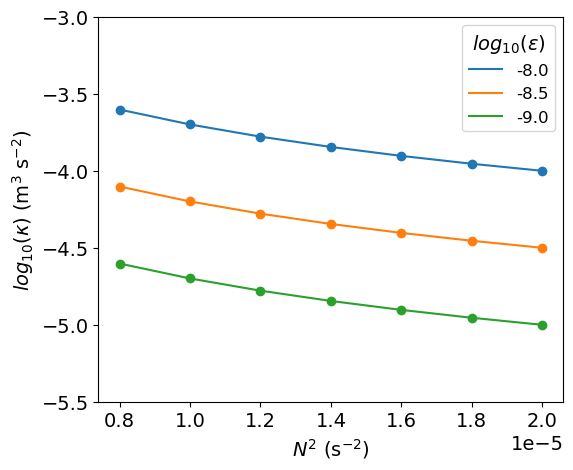

In [42]:
fig, ax = plt.subplots(figsize = (6,5))

for eps in eps_log:
    e = 10**float(eps)
    
    kappa = diffusivity(e, N2_range)
    
    plt.plot(N2_range, np.log10(kappa))
    plt.scatter(N2_range, np.log10(kappa))
    
ax.set_ylim(-5.5, -3)
ax.legend(eps_log, title = '$log_{10}(\epsilon)$', fontsize = 12)
ax.set_xlabel('$N^{2}$ (s$^{-2}$)')
ax.set_ylabel('$log_{10}(\kappa)$ (m$^{3}$ s$^{-2}$)')

### Shear

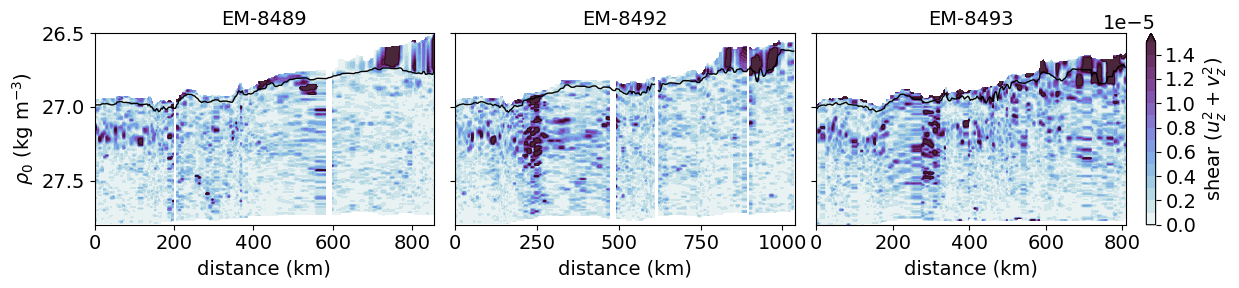

In [676]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.1))
axs = ax.flatten()

imp.reload(interp)
i = 0
for floatid in floatids:
    shear_even = interp.even_dist_grid(shear_dict[floatid], 3)
    p_on_d_even = interp.even_dist_grid(p_on_dens[floatid], 3)
    mld_even = interp.even_dist_grid(mld_on_d[floatid], 3)
    
    im = shear_even.plot.contourf(ax = axs[i], x = 'distance', cmap = cmocean.cm.dense, 
                                           levels = np.arange(0, 1.6e-5, 1e-6), alpha = 0.9, 
                                           add_colorbar = False)
    

    mld_even.plot(ax = axs[i], c = 'k', linewidth = 1)
    
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(26.5, 27.8)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\rho_{0}$ (kg m$^{-3}$)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = 'shear $(u_{z}^{2} + v_{z}^{2})$')

# settings.save_figure(fig, my_path, 'shear_3_floats.png', dpi = 600, pad = 0.2)

### Speed

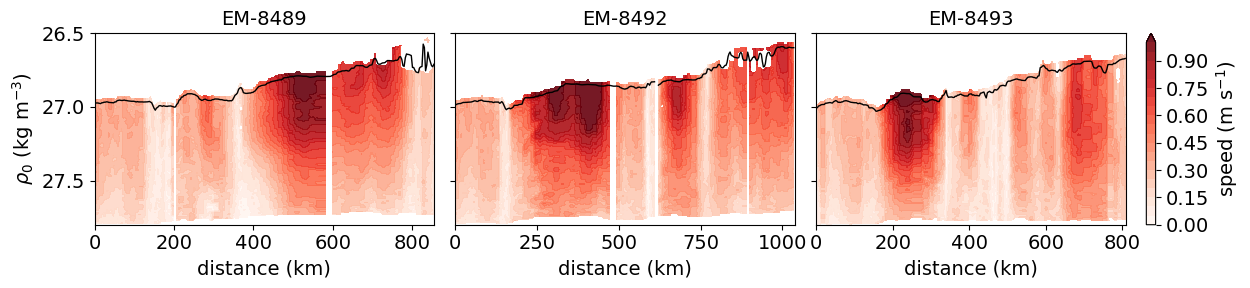

In [43]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.1))
axs = ax.flatten()

imp.reload(interp)
i = 0
for floatid in floatids:
    speed = calc.speed(ds[floatid].u_abs, ds[floatid].v_abs)
    speed_dens = interp.varToDens(speed, pdens = dens[floatid], dens_interval = 0.01, by_dist = True, rs = False)
    speed_even = interp.even_dist_grid(speed_dens, 3)

    p_on_d_even = interp.even_dist_grid(p_on_dens[floatid], 3)
    mld_even = interp.even_dist_grid(mld_on_d[floatid], 3)
    
    im = speed_even.plot.contourf(ax = axs[i], x = 'distance', cmap = 'Reds', 
                                           levels = np.arange(0, 1.05, 0.05), alpha = 0.9, 
                                           add_colorbar = False)
    

    mld_even.plot(ax = axs[i], c = 'k', linewidth = 1)
    
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(26.5, 27.8)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\rho_{0}$ (kg m$^{-3}$)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = 'speed (m s$^{-1}$)')

# settings.save_figure(fig, my_path, 'speed_3_floats.png', dpi = 600, pad = 0.2)

### Individual sections

In [40]:
floatid =  8493 #8492 #8489 #
d1, d2 =   200,400 #700,1100 #375,575 #
pd1, pd2 = 26.9, 27.4

In [41]:
i1 = np.where(ds[floatid].distance >= d1)[0][0]
i2 = np.where(ds[floatid].distance <= d2)[0][-1]+1

no_ticks = 4
tick_start = 3 #8

t = ds[floatid].time[i1:i2].dt.strftime("%m-%d\nT%H:%M")
tickinterval = int(len(t)/no_ticks)
print(tickinterval)

12


In [42]:
## evenly grid in distance (3 km intervals)
dsc_even_grid = interp.even_dist_grid(DSC_smooth[floatid], 3)
pres_dens = interp.even_dist_grid(p_on_dens[floatid], 3)

Text(0.5, 1.0, 'EM-8492')

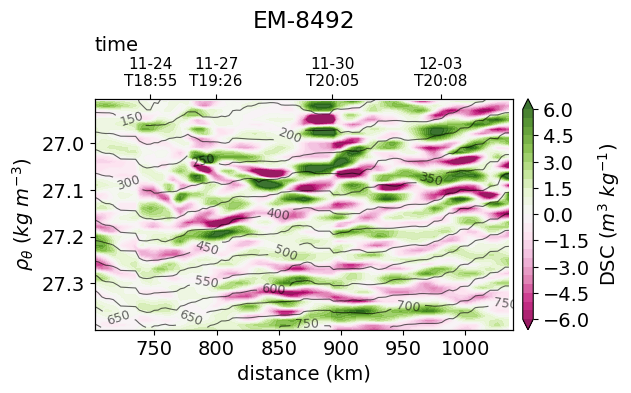

In [53]:
dsc_sel = dsc_even_grid.sel(potential_density = slice(pd1, pd2), 
                        distance = slice(d1,d2))

fig, ax = plt.subplots(figsize = (6.5,3))
dsc_sel.plot.contourf(x = 'distance', cmap = 'PiYG', 
                      cbar_kwargs = dict(label = 'DSC ($m^{3}$ $kg^{-1}$)', pad = 0.02),
                      levels = np.arange(-6,6.5, 0.5),
                       alpha = 0.9)

CS = pres_dens.sel(potential_density = slice(pd1, pd2), 
                            distance = slice(d1,d2)).plot.contour(ax = ax, 
                                x = 'distance', 
                                levels = np.arange(50, 800, 50),
                                linewidths = 0.8, 
                                colors = 'k', 
                                alpha = 0.6)

ax.clabel(CS, inline=True, fontsize=9, fmt = '%1.0f')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ds[floatid].distance.sel(distance = slice(d1,d2)).distance[tick_start:-1:tickinterval])
ax2.set_xticklabels(t.data[tick_start:-1:tickinterval], multialignment='center', fontsize = 11)
ax2.set_xlabel('time', loc = 'left')

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'EM-{floatid}')

# settings.save_figure(fig, my_path, f'DSC_sel_EM-{floatid}.png', dpi = 600, pad = 0.2)

In [43]:
even_dens = interp.even_dist_grid(dens[floatid], 3)
# nonans = np.where(~np.isnan(ds[floatid].u_abs.mean(dim = 'pressure', skipna = True)))[0]
# u_even = interp.even_dist_grid(ds[floatid].u_abs[nonans], 3)#.interpolate_na(dim = 'distance', max_gap = 15)
# v_even = interp.even_dist_grid(ds[floatid].v_abs[nonans], 3)#.interpolate_na(dim = 'distance', max_gap = 15)

In [56]:
u_dens = interp.varToDens(u_even, pdens = even_dens, dens_interval = 0.01, by_dist = True, rs = False)
v_dens = interp.varToDens(v_even, pdens = even_dens, dens_interval = 0.01, by_dist = True, rs = False)

Text(0.5, 1.0, 'EM-8492')

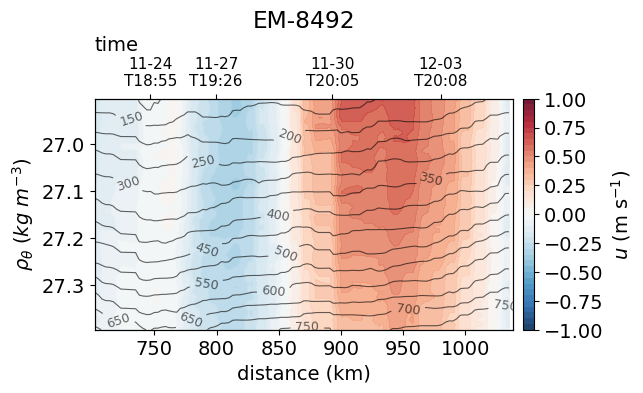

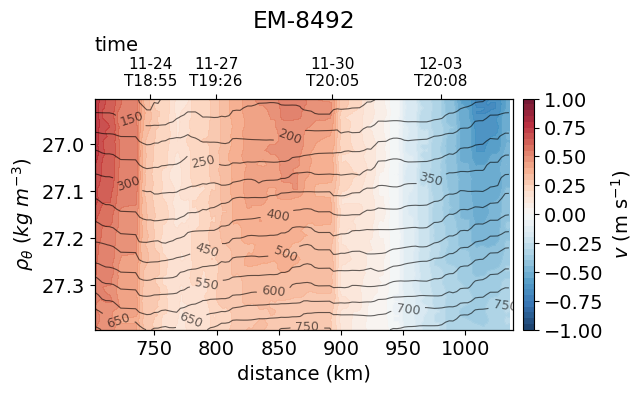

In [57]:
fig, ax = plt.subplots(figsize = (6.5,3))
u_dens.sel(distance = slice(d1,d2), potential_density = slice(pd1, pd2)).plot.contourf(
                                        x = 'distance', cmap = 'RdBu_r', 
                                        levels = np.arange(-1,1.05,0.05),
                                        cbar_kwargs = dict(label = '$u$ (m s$^{-1}$)', pad = 0.02),
                                        alpha = 0.9)

CS = pres_dens.sel(potential_density = slice(pd1, pd2), 
                            distance = slice(d1,d2)).plot.contour(ax = ax, 
                                                                x = 'distance', 
                                                                levels = np.arange(50, 800, 50), 
                                                                linewidths = 0.8, 
                                                                colors = 'k', 
                                                                alpha = 0.6)
ax.clabel(CS, inline=True, fontsize=9, fmt = '%1.0f')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ds[floatid].distance.sel(distance = slice(d1,d2))[tick_start:-1:tickinterval])
ax2.set_xticklabels(t.data[tick_start:-1:tickinterval], multialignment='center', fontsize = 11)
ax2.set_xlabel('time', loc = 'left')

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'EM-{floatid}')

fig, ax = plt.subplots(figsize = (6.5,3))
v_dens.sel(distance = slice(d1,d2), potential_density = slice(pd1, pd2)).plot.contourf(
                                        x = 'distance', cmap = 'RdBu_r', 
                                        levels = np.arange(-1,1.05,0.05),
                                        cbar_kwargs = dict(label = '$v$ (m s$^{-1}$)', pad = 0.02),
                                        alpha = 0.9)

CS = pres_dens.sel(potential_density = slice(pd1, pd2), 
                            distance = slice(d1,d2)).plot.contour(ax = ax, 
                                                                x = 'distance', 
                                                                levels = np.arange(50, 800, 50), 
                                                                linewidths = 0.8, 
                                                                colors = 'k', 
                                                                alpha = 0.6)
ax.clabel(CS, inline=True, fontsize=9, fmt = '%1.0f')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ds[floatid].distance.sel(distance = slice(d1,d2)).distance[tick_start:-1:tickinterval])
ax2.set_xticklabels(t.data[tick_start:-1:tickinterval], multialignment='center', fontsize = 11)
ax2.set_xlabel('time', loc = 'left')

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'EM-{floatid}')

In [58]:
speed = calc.speed(u_dens, v_dens)

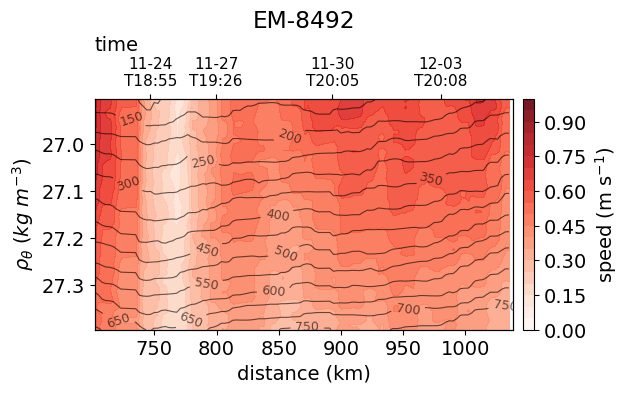

In [60]:
fig, ax = plt.subplots(figsize = (6.5,3))
speed.sel(distance = slice(d1,d2), potential_density = slice(pd1, pd2)).plot.contourf(
                                        x = 'distance', cmap = 'Reds', 
                                        levels = np.arange(0,1.05,0.05),
                                        cbar_kwargs = dict(label = 'speed (m s$^{-1}$)', pad = 0.02),
                                        alpha = 0.9)

CS = pres_dens.sel(potential_density = slice(pd1, pd2), 
                            distance = slice(d1,d2)).plot.contour(ax = ax, 
                                                                x = 'distance', 
                                                                levels = np.arange(50, 800, 50), 
                                                                linewidths = 0.8, 
                                                                colors = 'k', 
                                                                alpha = 0.6)
ax.clabel(CS, inline=True, fontsize=9, fmt = '%1.0f')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ds[floatid].distance.sel(distance = slice(d1,d2))[tick_start:-1:tickinterval])
ax2.set_xticklabels(t.data[tick_start:-1:tickinterval], multialignment='center', fontsize = 11)
ax2.set_xlabel('time', loc = 'left')

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'EM-{floatid}')

# settings.save_figure(fig, my_path, f'speed_sel_EM-{floatid}.png', dpi = 600, pad = 0.2)

### Vertical shear

In [61]:
shear_smooth = shear[floatid].rolling(distance = 3, center = True, min_periods = 2).mean()
nonans = np.where(~np.isnan(shear_smooth.mean(dim = 'pressure', skipna = True)))[0]

shear_even = interp.even_dist_grid(shear_smooth[nonans], 3)
shear_dens = interp.varToDens(shear_even, pdens = even_dens, dens_interval = 0.01, by_dist = True, rs = False)

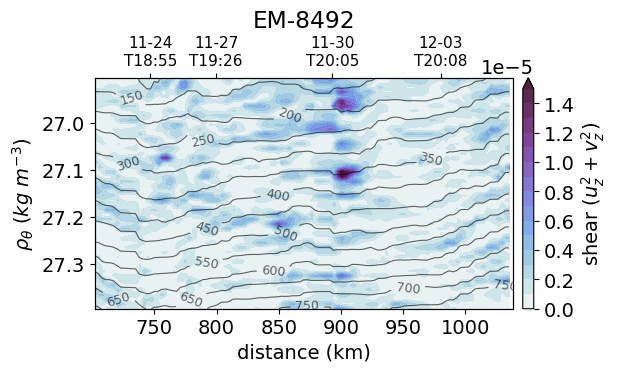

In [63]:
fig, ax = plt.subplots(figsize = (6.5,3))
shear_dens.sel(distance = slice(d1,d2), potential_density = slice(pd1, pd2)).plot.contourf(
                                        x = 'distance', cmap = cmocean.cm.dense, levels = np.arange(0, 1.6e-5, 1e-6),
                                        cbar_kwargs = dict(label = 'shear $(u_{z}^{2} + v_{z}^{2})$', pad = 0.02),
                                        alpha = 0.9)

CS = pres_dens.sel(potential_density = slice(pd1, pd2), 
                            distance = slice(d1,d2)).plot.contour(ax = ax, 
                                                                x = 'distance', 
                                                                levels = np.arange(50, 800, 50), 
                                                                linewidths = 0.8, 
                                                                colors = 'k', 
                                                                alpha = 0.6)
ax.clabel(CS, inline=True, fontsize=9, fmt = '%1.0f')

# CS2 = speed.sel(distance = slice(d1,d2), potential_density = slice(pd1, pd2)).plot.contour(
#                                         x = 'distance', cmap = 'Reds', alpha = 0.8,
#                                         levels = np.arange(0,1.05,0.05), linewidths = 0.8)


ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ds[floatid].distance.sel(distance = slice(d1,d2)).distance[tick_start:-1:tickinterval])
ax2.set_xticklabels(t.data[tick_start:-1:tickinterval], multialignment='center', fontsize = 11)
# ax2.set_xlabel('time', loc = 'left')

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'EM-{floatid}')

# settings.save_figure(fig, my_path, f'shear_sel_EM-{floatid}.png', dpi = 600, pad = 0.2)

### Richardson number

In [44]:
Ri_smooth = Ri[floatid].rolling(distance = 3, center = True, min_periods = 2).mean()
nonans = np.where(~np.isnan(Ri_smooth.mean(dim = 'pressure', skipna = True)))[0]

Ri_even = interp.even_dist_grid(Ri_smooth[nonans], 3)
Ri_dens = interp.varToDens(Ri_even, pdens = even_dens, dens_interval = 0.01, by_dist = True, rs = False)

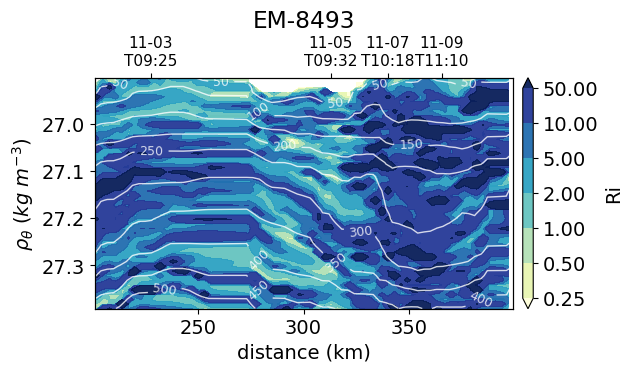

In [46]:
fig, ax = plt.subplots(figsize = (6.5,3))
Ri_dens.sel(distance = slice(d1,d2), potential_density = slice(pd1, pd2)).plot.contourf(
                                        x = 'distance', cmap = 'YlGnBu',
                                        levels = np.asarray([0.25, 0.5, 1, 2, 5, 10, 50]), 
                                        cbar_kwargs = dict(label = 'Ri', pad = 0.02),
                                        alpha = 0.95)


CS = pres_dens.sel(potential_density = slice(pd1, pd2), 
                            distance = slice(d1,d2)).plot.contour(ax = ax, 
                                                                x = 'distance', 
                                                                levels = np.arange(50, 800, 50), 
                                                                linewidths = 1, 
                                                                colors = 'w', 
                                                                alpha = 0.8)
ax.clabel(CS, inline=True, fontsize=9, fmt = '%1.0f')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ds[floatid].distance.sel(distance = slice(d1,d2)).distance[tick_start:-1:tickinterval])
ax2.set_xticklabels(t.data[tick_start:-1:tickinterval], multialignment='center', fontsize = 11)
# ax2.set_xlabel('time', loc = 'left')

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'EM-{floatid}')

# settings.save_figure(fig, my_path, f'Ri_sel_EM-{floatid}.png', dpi = 600, pad = 0.2)

### Buoyancy frequency

In [67]:
# floatid = 8489
# d1, d2 = 0, 200
# pd1, pd2 = 26.9, 27.4

In [68]:
N2_dens = interp.varToDens(N2[floatid], pdens = dens[floatid].interp(pressure = N2[floatid].pressure), 
                           dens_interval = 0.01, by_dist = True, rs = False, PV = True)

N2_even = interp.even_dist_grid(N2_dens, 3)

Text(0.5, 1.0, 'EM-8492')

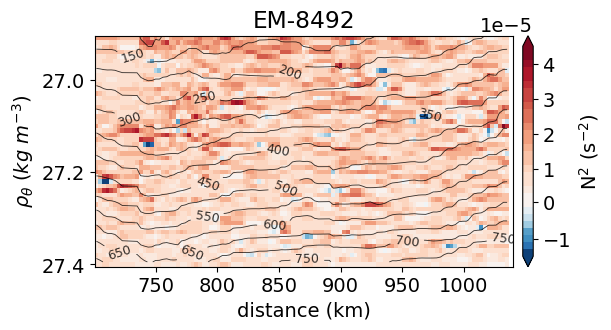

In [69]:
vmin, vmax = -1.5e-5, 4.5e-5
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig, ax = plt.subplots(figsize = (6.5,3))
N2_even.sel(potential_density = slice(pd1, pd2),
                   distance = slice(d1, d2)).plot(
                        x = 'distance', norm = norm, 
                        levels = np.arange(vmin,vmax, 2e-6), 
                        cbar_kwargs = dict(label = 'N$^{2}$ (s$^{-2}$)', pad = 0.02))

CS = pres_dens.sel(potential_density = slice(pd1, pd2),
                            distance = slice(d1, d2)).plot.contour(
                            x = 'distance', levels = np.arange(50, 800, 50), 
                            linewidths = 0.6, colors = 'k', alpha = 0.8)

ax.clabel(CS, inline=True, fontsize=9, fmt = '%1.0f')
    
ax.invert_yaxis()
# ax.set_xlim(450,650)
ax.set_xlabel('distance (km)')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'EM-{floatid}')